# Building a RAG Pipeline

This notebook constructs a retrieval-augmented generation (RAG) pipeline using the pre-built vector index of ~5,000 Wikipedia article summaries.

The LLM used in this project is a quantized `Llama-3.2-1B-Instruct-Q4_0` model, deployed locally using the `GPT4All` library.

In [1]:
import json
import logging

import chromadb
import pandas as pd

from chromadb.config import Settings
from IPython.display import Image, display
from langchain_chroma import Chroma
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_community.llms.gpt4all import GPT4All
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

In [2]:
logging.basicConfig(level=logging.INFO)

pd.options.display.max_colwidth = 200

## Initialize the LLM and embedding model

In [3]:
embeddings = GPT4AllEmbeddings(
    model_name="all-MiniLM-L6-v2.gguf2.f16.gguf",
    n_threads=8,
)

Failed to load libllamamodel-mainline-cuda.so: dlopen: libcudart.so.11.0: cannot open shared object file: No such file or directory
Failed to load libllamamodel-mainline-cuda-avxonly.so: dlopen: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [4]:
llm = GPT4All(
    model="Llama-3.2-1B-Instruct-Q4_0.gguf",
    allow_download=True,
    n_threads=8,
)

## Load the Chroma vector store

In [5]:
chroma_client = chromadb.PersistentClient(
    path="../data/database/wikipedia.db",
    settings=Settings(allow_reset=True),
)

INDEX_NAME = "wikipedia-index"
vector_store = Chroma(
    client=chroma_client,
    collection_name=INDEX_NAME,
    embedding_function=embeddings,
)

INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


In [6]:
vector_store._chroma_collection.count()

7873

## Define the RAG prompt template

We create a chat prompt that instructs the LLM to answer questions only with retrieved context, citing sources, or admit ignorance.

In [14]:
prompt_template = """Answer the question based only on the context.
Cite the source of the information in the format [source: doc1].
If the answer is not provided in the documents, say "I don't know."

Context:
{context}

Question: {question}

Answer: """

prompt = ChatPromptTemplate.from_template(prompt_template)

### Define the RAG workflow functions

We use a `TypedDict` to track state, and write two functions:

* `retrieve`: Perform vector similarity search and attach the top-K documents to state.
* `generate`: Format retrieved docs into JSON context, invoke the LLM with our prompt, and return the answer.

In [33]:
NEWLINE = "\n"


class State(TypedDict):
    question: str
    top_k: int
    context: List[Document]
    answer: str


def retrieve(state: State):
    top_k = state.get("top_k", 0)
    if top_k > 0:
        retrieved_docs = vector_store.search(
            state["question"],
            search_type="similarity",
            k=top_k,
        )
    else:
        retrieved_docs = []
    logging.info(f"Retrieved {len(retrieved_docs)} documents")

    for i, doc in enumerate(retrieved_docs, start=1):
        logging.info(f"  Document {i}: {doc.metadata['title']}")
        logging.info(f"  Content: {doc.page_content[:100].replace(NEWLINE, '  ')}...")

    return {"context": retrieved_docs}


def generate(state: State):
    # docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    docs_content = {
        f"[doc{doc_id}]": {
            "title": doc.metadata["title"],
            "content": doc.page_content,
        }
        for doc_id, doc in enumerate(state["context"])
    }
    docs_content = json.dumps(docs_content, indent=2)

    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response}

### Assemble and Visualize the graph

In [34]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

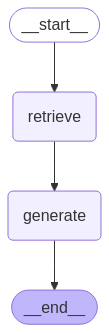

In [35]:
display(Image(graph.get_graph().draw_mermaid_png()))

## Query the RAG pipeline

Sample content for inspiration:

In [36]:
articles_df = pd.read_parquet("../data/input/wikipedia_articles.parquet")

In [37]:
articles_df[["title", "summary"]].sample(5)

,title,summary
3226,PJ Harvey,"Polly Jean Harvey (born 9 October 1969) is an English singer-songwriter. Primarily known as a vocalist and guitarist, she is also proficient with a wide range of instruments.\nHarvey began her ca..."
1326,GK Software,"GK Software SE is a technology company headquartered in Schöneck/Vogtland. The company specializes in software and services for the operation of large retail company branches. GK employs about 1,2..."
4122,W. G. Sebald,"Winfried Georg Sebald (18 May 1944 – 14 December 2001), known as W. G. Sebald or (as he preferred) Max Sebald, was a German writer and academic. At the time of his death at the age of 57, he was a..."
662,Canon EF-S lens mount,The Canon EF-S lens mount is a derivative of the EF lens mount created for some Canon digital single-lens reflex cameras with APS-C sized image sensors. It was released in 2003. Cameras with the E...
1745,International unit,"In pharmacology, the international unit (IU) is a unit of measurement for the effect or biological activity of a substance, for the purpose of easier comparison across similar forms of substances...."


### Example: What's a flush toilet?

In [38]:
result = graph.invoke(
    {
        "question": "what's a flush toilet? answer briefly",
        "top_k": 3,
    },
)
print()
print(result["answer"])

INFO:root:Retrieved 0 documents



 A flush toilet is an ancient type of toilet that uses water to remove waste from human excrement. It typically consists of a bowl with a seat and lid, connected by pipes to a drainage system.

Source: [source doc1]


### Example: Is it centimeter or centimetre?

In [40]:
result = graph.invoke(
    {
        "question": "is it centimeter or centimetre",
        "top_k": 1,
    },
)
print()
print(result["answer"])

INFO:root:Retrieved 1 documents
INFO:root:  Document 1: Centimetre
INFO:root:  Content: Centimetre  A centimetre or centimeter (US/Philippine spelling), with SI symbol cm, is a unit of leng...



1
I don't know.

Source:
[doc0] = [source doc]
Note: The source document "doc0" contains information about units in different systems, including SI and CGS. However, the specific definition of a unit like centimeter depends on its context within that system. In this case, it is mentioned as being equal to one hundredth of a meter (1 cm = 100 m). Therefore, I will provide an answer based only on this information.

[doc0] {
  "title": "Centimetre",
  "content": "A centimeter or centi\u20601/100\u2060 is the SI symbol for one hundredth of a metre. It can also be expressed as \u2061 cm, where 'cm' stands for centimetres."
}

[doc0] {
  "title": "\u20601/100\u2060",
  "content": "The unit name in CGS is centimeter.\nIn the International System of Units (SI), it equals one hundredth of a metre. The term 'centimetre' was used as an alternative to \u20601/100\u2060, but this usage has largely been replaced by SI prefixes like milli- and
